# MSE 463: Project 3
## Kendra Noneman

### *Introduction*

*Sections 1-6 include all questions from both Project 2 and Project 3.*<br>
This notebook is intended to demonstrate fundamental knowledge with Molecular Dynamics simulations for MSE 463.<br>


### 1. Identify or develop a model for your equilibrium system of interest:

The model chosen is of fullerenes and oxidized-fullerenes. This system, which has been studied experimentally by Dr. Kevin Ausman, presents a challenging problem of solubilizing nonpolar fullerenes in water. One idea is to oxidize the C60 molecule, which adds a slight charge and can stabilize aqueous dispersions. In some of my previous work, seven coarse-grained models were created to study the effects of charge and temperature on structural transisions of these C60s. With the intended goal to allow fullerene oxides to form a shell around droplets of regular fullerenes, *we are now curious about the ratios necessary to see this type of behavior.* <br>

**a. What are the simplest components needed to represent your system?**<br>
The components needed to represent this sytem include a coarse-grain representation of a C60 molecule and oxygen.<br>
Type A: Oxidized C60<br>
Type B: Oxygen site attached to type A<br>
Type C: Solo un-oxidized C60<br>

**b. What kinds of interactions and sampling are needed to investigate this system?**<br>
In previous research, seven models were employed to understand the effects of charges and interaction strengths on structural characteristics. For this work, we will look at a specific range of interactions (CC interaction strength) and sample ratios from 0.1 to 0.9 of oxidized to un-oxidized fullerenes. <br>

**i. Can you implement them? If not, pick different interactions or systems.<br>**
Blah blah <br>

**c. What are your base units (length, mass, energy)?**<br>
Blah blah


### 2. Get your bearings:
The model chosen is... <br>
**a. For a few representative state points (defined by (temperature, density)) plot the number of steps you can sample per second versus N and make a case for the N you’ll use for your “production” runs.** <br>
Blah blah <br>
**b. Are there states where you can’t get equilibrium samples? Using these findings, specify where you’re *not* going to do sampling.**<br>
Blah blah <br>
**c. For the “production” N that you argue in 2a, at the coldest temperature and highest density where you *are* going to do sampling from 2b, what is:**<br>
Blah blah <br>
**i. The relaxation time?**<br>
Blah blah <br>
**ii. The decorrelation time after reaching equilibrium?**
Blah blah

### 3. Investigate structure/behavior:
The model chosen is... <br>
**a. Above what temperature is your system “hot”? How do you know?** <br>
Blah blah <br>
**b. Below what temperature is your system “frozen”? How do you know?** <br>
Blah blah <br>
**c. How does the system’s total energy, potential energy, kinetic energy, heat capacity and structure vary across statespace?** <br>
Blah blah <br>
**d. What’s the standard deviation and number of samples for every measurement you report?** <br>
Blah blah

### 4. Investigate model's performance:
Blah blah <br>
**a. How long does it take to equilibrate at the hot and frozen temperatures from above?** <br>
Blah blah <br>
**b. How long does it take to equilibrate in-between?** <br>
Blah blah <br>
**c. How small is too small to be correct? How large is too large to be practical?** <br>
Blah blah <br>
**d. Can you improve the performance of your simulations by changing how frequently you write out data?** <br>
Blah blah <br>
**e. Did you use this information when collecting data for part 1?** <br>
Blah blah

### 5. Contrast system with an ideal gas:
Blah blah <br>
**a. How does the structure of your model vary with state, and how does it compare to particles with no interactions?** <br>
Blah blah <br>
**b. Does the heat capacity of your system depend on state differently than an ideal gas?** <br>
Blah blah <br>
**c. Can you derive or numerically determine an equation of state?** <br>
Blah blah

### 6. Validate, Interpret, and Summarize:
Blah blah <br>
**a. Do your results match other similar systems in the simulation literature?** <br>
Blah blah <br>
**b. Do your results match experiments?** <br>
Blah blah <br>
**c. In what ways are your results expected and unexpected?** <br>
Blah blah <br>
**d. Summarize which metrics you found most useful for describing your system’s behavior** <br>
Blah blah <br>
**e. Which specific simulation and state point was your favorite (and why)?** <br>
Blah blah <br>
**f. Describe any revelations you had while working towards 1-5.** <br>
Blah blah

In [1]:
#Importing necessary packages

import hoomd, hoomd.md
import hoomd.deprecated as d
import numpy.random as rand
import sys
import os
import numpy
import fresnel
import gsd
import gsd.fl
import gsd.hoomd
import PIL
import IPython
import io
import math
import freud
import matplotlib.pyplot as plt
%matplotlib inline 

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
#Setting up important variables

T=1.0 #Temperature
nr=6 #Size of unit cell
cc_eps=1.0

maxT=1e5
dcdPeriod=1e6
msdPeriod=1e5
pppmGrid=64
pppmOrder=6
rcut=2.5
dt=0.001

#Helper classes for visualization and analysis
class rdf_analyze:
    def __init__(self, system):
        self.system = system;
        self.rdf = freud.density.RDF(rmax=4.0, dr=0.01); #Can update range and stepsize here
        
    def __call__(self, step):
        '''This special function defines what happens when we "register" the callback below'''
        snap = system.take_snapshot();
        pos = snap.particles.position;
        box = freud.box.Box(snap.box.Lx, snap.box.Ly, snap.box.Lz);
        self.rdf.accumulate(box, pos, pos);

device = fresnel.Device(mode='cpu');
preview_tracer = fresnel.tracer.Preview(device, 300, 300, aa_level=3)
path_tracer = fresnel.tracer.Path(device, 300, 300)

blue = fresnel.color.linear([0.25,0.5,1])*0.9;
orange = fresnel.color.linear([1.0,0.714,0.169])*0.9

def render_sphere_frame(frame, height=None):

    if height is None:
        if hasattr(frame, 'configuration'):
            Ly = frame.configuration.box[1]
            height = Ly * math.sqrt(3)
        else:
            Ly = frame.box.Ly;
            height = Ly * math.sqrt(3)

    scene = fresnel.Scene(device)
    scene.lights = fresnel.light.cloudy();
    g = fresnel.geometry.Sphere(scene, position=frame.particles.position, radius=numpy.ones(frame.particles.N)*0.5)
    g.material = fresnel.material.Material(solid=0.0, color=blue, primitive_color_mix=1.0, specular=1.0, roughness=0.2)
    g.outline_width = 0.07
    scene.camera = fresnel.camera.orthographic(position=(height, height, height), look_at=(0,0,0), up=(0,1,0), height=height)

    g.color[frame.particles.typeid == 0] = blue;
    g.color[frame.particles.typeid == 1] = orange;

    scene.background_color = (1,1,1)

    return path_tracer.sample(scene, samples=64, light_samples=20)

def display_movie(frame_gen, gsd_file):
    f = gsd.fl.GSDFile(gsd_file, 'rb')
    t = gsd.hoomd.HOOMDTrajectory(f)

    a = frame_gen(t[0]);

    if tuple(map(int, (PIL.__version__.split(".")))) < (3,4,0):
        print("Warning! Movie display output requires pillow 3.4.0 or newer.")
        print("Older versions of pillow may only display the first frame.")

    im0 = PIL.Image.fromarray(a[:,:, 0:3], mode='RGB').convert("P", palette=PIL.Image.ADAPTIVE);
    ims = [];
    for f in t[1:]:
        a = frame_gen(f);
        im = PIL.Image.fromarray(a[:,:, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0);
        ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    if (sys.version_info[0] >= 3):
        size = len(f.getbuffer())/1024;
        if (size > 2000):
            print("Size:", size, "KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [6]:
hoomd.context.initialize("");
uc = hoomd.lattice.unitcell(N=2,    #two types of particles
            a1=[3,0,0],             #unit cell axes
            a2=[0,3,0,],
            a3=[0,0,3],
            dimensions=3,
            position=[[0,0,0],[0,1.5,0]], #xyz coords of the N particles
            type_name=['R','C'],
            mass=[1.022222,1.0],
            diameter = [0.1,1.0], #Just the diameter we draw, not the one we use
            moment_inertia=[[5.047,5.303,5.300],[0,0,0]], #new and improved moments
            orientation=[[1,0,0,0],[1,0,0,0]])
system = hoomd.init.create_lattice(unitcell=uc,n=[nr,nr,nr])
system.particles.types.add('A')
system.particles.types.add('B')
rigid=hoomd.md.constrain.rigid()
analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
hoomd.analyze.callback(analyzer, period=100);

### CHARGES
rigid.set_param('R',types=['A','B'],positions=[[-0.0104,0.,0.],[0.4673,0.,0.]],diameters=[1.0,.272],charges=[0,0]) #proper dipole moment
rigid.create_bodies()
nl = hoomd.md.nlist.tree()
lj = hoomd.md.pair.lj(r_cut=rcut,nlist=nl)
lj.set_params(mode='xplor') #Interactions
lj.pair_coeff.set('A','A',epsilon=1.0,sigma=1.0)
lj.pair_coeff.set('B','B',epsilon=0.06,sigma=.272) #little oxygens
lj.pair_coeff.set('C','C',epsilon=cc_eps,sigma=1.0)
lj.pair_coeff.set('R',['R','A','B','C'],epsilon=0.0,sigma=0.0) #rigid points
lj.pair_coeff.set('B',['A','C'],epsilon=0.25,sigma=.636) #oxygen with fullerene
lj.pair_coeff.set('A','C',epsilon=1.0,sigma=1.0)
#char = hoomd.group.charged()
#pppm = hoomd.md.charge.pppm(group=char,nlist=nl)
#pppm.set_params(Nx=pppmGrid,Ny=pppmGrid,Nz=pppmGrid,order=pppmOrder,rcut=rcut)
hoomd.md.integrate.mode_standard(dt=dt)
ta=hoomd.group.type(name='as',type='A')
tb=hoomd.group.type(name='bs',type='B')
tc=hoomd.group.type(name='cs',type='C')

#potential energy v. time 
logger = hoomd.analyze.log(filename="log.log", quantities=['potential_energy', 'temperature', 'kinetic_energy'], period=1e3, header_prefix='#', overwrite=True)

all = hoomd.group.all()
rigid = hoomd.group.rigid_center()
a=d.analyze.msd(filename="msd.log",groups=[ta,tb,tc,rigid],period=msdPeriod,overwrite=True)
hoomd.md.integrate.langevin(group=hoomd.group.union(name='all',a=rigid,b=hoomd.group.type('C')),kT=T,seed=rand.randint(2**32)) ###
d.dump.xml(group=hoomd.group.all(),filename="init.xml",vis=True, inertia=True,orientation=True,constraint=True)
#hoomd.dump.dcd(group=hoomd.group.all(),filename="traj.dcd",overwrite=True,period=dcdPeriod)
hoomd.dump.gsd("trajectory.gsd", period=2e3, group=all, overwrite=True)
hoomd.run(maxT)
d.dump.xml(group=hoomd.group.all(),filename="restart.xml",vis=True, inertia=True,orientation=True,constraint=True)

notice(2): Group "all" created containing 432 particles
notice(2): constrain.rigid(): Creating 216 rigid bodies (adding 432 particles)
-----
You are using tree neighbor lists. Please cite the following:
* M P Howard, J A Anderson, A Nikoubashman, S C Glotzer, and A Z
  Panagiotopoulos. "Efficient neighbor list calculation for molecular simulation
  of colloidal systems using graphics processing units", Computer Physics
  Communications 203 (2016) 45--52
-----
notice(2): Group "as" created containing 216 particles
notice(2): Group "bs" created containing 216 particles
notice(2): Group "cs" created containing 216 particles
notice(2): Group "rigid_center" created containing 216 particles
notice(2): Group "type C" created containing 216 particles
notice(2): Group "all" created containing 432 particles


*Warning*: compute.thermo already specified for a group with name all


notice(2): integrate.langevin/bd is using specified gamma values


*Warning*: analyze.log: The log quantity temperature has been registered more than once. Only the most recent registration takes effect
*Warning*: analyze.log: The log quantity translational_temperature has been registered more than once. Only the most recent registration takes effect
*Warning*: analyze.log: The log quantity rotational_temperature has been registered more than once. Only the most recent registration takes effect
*Warning*: analyze.log: The log quantity kinetic_energy has been registered more than once. Only the most recent registration takes effect
*Warning*: analyze.log: The log quantity translational_kinetic_energy has been registered more than once. Only the most recent registration takes effect
*Warning*: analyze.log: The log quantity rotational_kinetic_energy has been registered more than once. Only the most recent registration takes effect
*Warning*: analyze.log: The log quantity potential_energy has been registered more than once. Only the most recent registrati

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 864
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:10 | Step 13569 / 100000 | TPS 1356.89 | ETA 00:01:03
Time 00:00:20 | Step 27001 / 100000 | TPS 1341.87 | ETA 00:00:54
Time 00:00:30 | Step 40460 / 100000 | TPS 1345.72 | ETA 00:00:44
Time 00:00:40 | Step 53840 / 100000 | TPS 1337.95 | ETA 00:00:34
Time 00:00:50 | Step 67255 / 100000 | TPS 1341.48 | ETA 00:00:24
Time 00:01:00 | Step 80938 / 100000 | TPS 1368.29 | ETA 00:00:13
Time 00:01:10 | Step 94701 / 100000 | TPS 1374.79 | ETA 00:00:03
Time 00:01:13 | Step 100000 / 100000 | TPS 1365.07 | ETA 00:00:00
Average TPS: 1353.06
---------
-- Neighborlist stats:
1238 normal updates / 1000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 38 / n_neigh_avg: 8.43981
shortest rebuild period: 38
** run complete **


Text(0, 0.5, 'potential_energy')

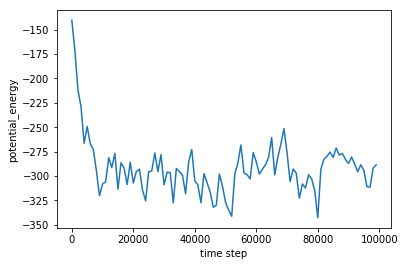

In [7]:
data = numpy.genfromtxt(fname='log.log', skip_header=True)
plt.plot(data[:,0], data[:,1]) #0th index is step, the other indices correspond to the order in which you specified the analyze.log
plt.xlabel('time step')
plt.ylabel('potential_energy') #1th index is pe because we put it first in log

Text(0, 0.5, 'g_AA')

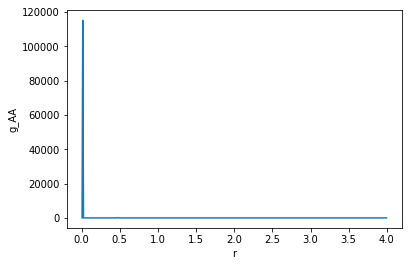

In [8]:
plt.plot(analyzer.rdf.R, analyzer.rdf.RDF) #use that accumulated RDF!
plt.xlabel('r')
plt.ylabel('g_AA')

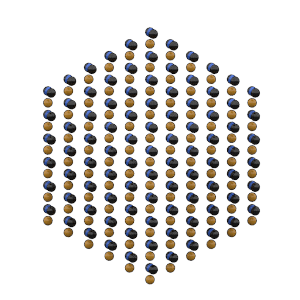

In [9]:
display_movie(render_sphere_frame, 'trajectory.gsd');